In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class ODENet(tf.keras.Model):
    def __init__(self):
        super(ODENet, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(100, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

model = ODENet()

In [12]:

# differential equation 
# y'' = x, y(0) = 0, y(1) = 0

# Define the analytical solution
def true_y(t):
    return(1/6)*t*((t**2)-1)

def f(x):
    return x

def loss_fn(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        dy_dx = tape.gradient(y, x)
    d2y_dx2 = tape.gradient(dy_dx, x)

    # Residual from the differential equation
    residual = d2y_dx2 - f(x)

    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))

    # Add boundary conditions to the loss
    loss += tf.square(model(tf.constant([[0.0]], dtype=tf.float32)))
    loss += tf.square(model(tf.constant([[1.0]], dtype=tf.float32)))
    
    return loss

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

x_samples = tf.convert_to_tensor(np.linspace(0, 1, 500).reshape(-1, 1), dtype=tf.float32)

epochs = 10000

for step in range(epochs):
    loss = train_step(model, x_samples)
    if step % 1000 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")

Step: 0, Loss: [[0.3988752]]
Step: 1000, Loss: [[1.6187118e-06]]
Step: 2000, Loss: [[1.9505227e-05]]
Step: 3000, Loss: [[2.3952205e-05]]
Step: 4000, Loss: [[8.841396e-06]]
Step: 5000, Loss: [[4.7634653e-06]]
Step: 6000, Loss: [[2.6244086e-05]]
Step: 7000, Loss: [[6.568259e-06]]
Step: 8000, Loss: [[3.5430843e-05]]
Step: 9000, Loss: [[3.397141e-05]]


32/32 [==============================] - 0s 1ms/step


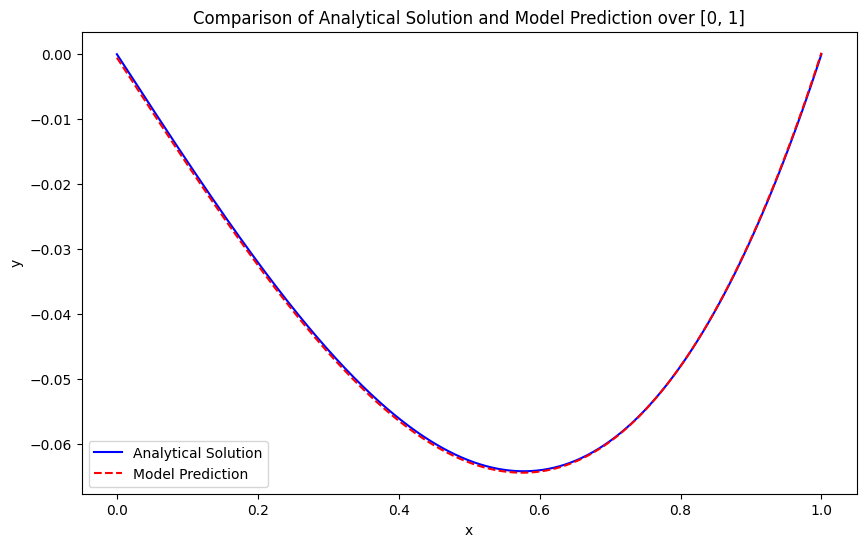

In [14]:
test_n = 1000
x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
y_true = true_y(x_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [0, 1]')
plt.show()